# Python for Finance
## Assignment 2

### Team: 11
Leonardo Fachetti (2722752)

Marc Peter van Gils (2703225)

Mark de Kwaasteniet (2649271)

In [7]:
%reset
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy
import scipy.stats

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Data input
These lines are dedicated to reading the WRDS data, inspecting the values and merging them into dataframes that we can do analyses with.

In [8]:
#Load in the csv data set from CRSP
df_crsp_org = pd.read_csv('crsp_new.csv')

In [9]:
#Check the data for strange datatypes as we already see a 'C' if we use head.
df_crsp_org.dtypes #Here we see that the return variable that we need, is an object and not numerical.

PERMNO      int64
date        int64
TICKER     object
RET        object
sprtrn    float64
dtype: object

In [10]:
#Looking into the data documentation there are different strings possible in the RET column: 'C', 'B' and '-'
#We have to make sure that these values are replaced by NaN instead of these strings. 
#We can check seperately if B and - are also in the dataframe or we can replace all just to be sure.
df_crsp = df_crsp_org.copy()
df_crsp.RET.replace('C',np.NaN, inplace=True)
df_crsp.RET.replace('B',np.NaN, inplace=True)
df_crsp.RET.replace('-',np.NaN, inplace=True)

#Check how many missing values the dataset has.
df_crsp.isnull().sum().sum() #451

451

In [11]:
#Drop the rows with NA values 
df_crsp.dropna(inplace=True)

#Now we can make it numerical - float32 bit
df_crsp.RET = pd.to_numeric(df_crsp.RET,downcast='float')

In [12]:
#Convert the date column values into a datetime variable.
df_crsp.date = pd.to_datetime(df_crsp['date'], format='%Y%m%d')

#Set date column as an index for the dataframe
df_crsp = df_crsp.set_index(['date'])

In [13]:
#Load in the csv data set from the FAMA FRENCH Three Factor Model
df_ff_org = pd.read_csv('ffmom.csv') #the variables are allready numerical - float64 bit

In [14]:
#Retain the original df
df_ff = df_ff_org.copy()

#Check for missing values
df_ff.isnull().sum().sum() #0

0

In [15]:
#Convert the dateff column values into a datetime variable.
df_ff['dateff'] = pd.to_datetime(df_ff['dateff'], format='%Y%m%d')

#Set dateff column as an index for the dataframe
df_ff = df_ff.set_index(['dateff'])

In [16]:
#Merge the CRSP dataset with the FFMOM dataset. They have the same index and same time period.
df_crsp_ff = pd.merge(df_ff,df_crsp,left_index=True, right_index=True)

In [17]:
#Specificy the variables we want to keep in the pivoted table.
variables_interest = ['index', 'mktrf', 'smb', 'hml', 'rf', 'umd', 'sprtrn']

#Reset the index in order to select 'index' as a column
df_crsp_ff = df_crsp_ff.reset_index()

#Pivot the table, including the variables of interest.
df_crsp_ff = df_crsp_ff.pivot_table(index=variables_interest, columns ='TICKER', values = 'RET')

#Reset the index again, because the pivot table created index of all the interest variables.
df_crsp_ff.reset_index(inplace=True)
df_crsp_ff.columns.name = None

#Set the index as time to complete the dataframe
df_crsp_ff = df_crsp_ff.set_index(['index'])

In [18]:
# For the portfolio creation we would like to have the yearly average risk free rate for every year that we form a portfolio for.
df_rf = df_crsp_ff.rf.resample('Y').mean()

#Note that this also creates a value for 2005 and 2019. We have to use the .iloc function later on to specificy this.
#To the cases we need the 2005-2018 rf's and when we need the 2006-2019 rf's.

In [19]:
df_crsp_ff

,mktrf,smb,hml,rf,umd,sprtrn,ABGX,ABVT,ADI,ADP,...,VRSN,VRTX,WCRX,WDAY,WDC,WYNN,XEL,XMSR,XRAY,ZM
index,,,,,,,,,,,,,,,,,,,,,
2005-01-31,-0.0276,-0.0172,0.0207,0.0016,0.0319,-0.025290,-0.150870,NaN,-0.027898,-0.019617,...,-0.230952,-0.037843,NaN,NaN,-0.006458,-0.020323,-0.000549,-0.151781,-0.002313,NaN
2005-02-28,0.0189,-0.0057,0.0154,0.0016,0.0318,0.018903,-0.059225,NaN,0.024798,-0.011960,...,0.061146,0.134710,NaN,NaN,0.045497,0.091672,-0.025838,0.032905,-0.019618,NaN
2005-03-31,-0.0197,-0.0140,0.0205,0.0021,0.0055,-0.019118,-0.152542,NaN,-0.015795,0.049930,...,0.046681,-0.188908,NaN,NaN,0.132327,-0.053514,-0.018764,-0.040352,-0.009096,NaN
2005-04-29,-0.0261,-0.0393,0.0005,0.0021,-0.0085,-0.020109,-0.004286,NaN,-0.056170,-0.033593,...,-0.078397,0.018162,NaN,NaN,-0.004706,-0.218482,0.000000,-0.122984,0.004043,NaN
2005-05-31,0.0365,0.0288,-0.0059,0.0024,0.0043,0.029952,0.032999,NaN,0.090003,0.008287,...,0.218147,0.460651,NaN,NaN,0.182821,-0.115036,0.072759,0.157534,0.044298,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30,-0.0258,-0.0232,-0.0495,0.0016,0.0764,-0.018092,NaN,NaN,-0.060361,0.019937,...,-0.034298,0.080423,NaN,-0.113511,0.062720,-0.145460,0.077336,NaN,-0.042241,-0.040205
2019-09-30,0.0143,-0.0097,0.0683,0.0018,-0.0685,0.017181,NaN,NaN,0.017299,-0.044925,...,-0.074663,-0.058882,NaN,-0.041291,0.041383,-0.012982,0.016739,NaN,0.024161,-0.168758
2019-10-31,0.0206,0.0028,-0.0193,0.0015,0.0029,0.020432,NaN,NaN,-0.045646,0.005018,...,0.007369,0.153819,NaN,-0.045893,-0.125587,0.116078,-0.021267,NaN,0.027575,-0.082808


### Creating the 4 portfolio's
#### Portfolio 1

In [13]:
# Set the constraints for all portfolios that we are forming. The total sum of the weight in all the assets should be equal to 1.
# We cannot invest more than 100%, therefore, this should be equal to one.
constraint = ({'type':'eq','fun': lambda x: np.sum(x)-1}) #This is a special constraint for the scipy.optimize function. 

# Type, is the type of constraint, in this case it is an equality constraint (eq). Meaning the result should be equal to zero.
# With this function the sum of the weights minus 1 should always be equal to zero.

In [14]:
# We create an empty dataframe in which we can store the number of stocks in the pool of each holding period.
df_tickers = pd.DataFrame(columns=['number_tickers'])

# We create this for question 7

#### Note
As mentioned earlier on the discussion board. The optimizer will run some false minimizations since it won't be able to find the direction in which it should optimize. This is due to the low number of observation for which we should optimize. 

In [15]:
# We create an empty dataframe in which we can store the returns for the portfolio
df_portfolio_1 = pd.DataFrame(columns=['return'])

for i in range(len(df_rf.iloc[1:])): #Skip the first one, because the rf dataset also includes 2019. However, we don't need that year for formation.
    # Now it will return an index of 0 - 13, leaving 14 = 2019 out.
    
    # Select the time windows that we want to use for the portfolio formation and holding. Column 6 is the first TICKER in the dataframe.
    df_portfolio = df_crsp_ff.iloc[(i*12):(24+i*12),6:]

    # The case notes that we should only use the stocks that have no missing values in both the formation and holding period.
    df_portfolio = df_portfolio.dropna(axis=1) # This line of code will drop all the columns that have a NaN value. 

    # Store the total number of tickers that are left without missing values in the formation/holding period. For later question.
    df_tickers.loc[i, ['number_tickers']] = len(df_portfolio.columns) # We use the index in the for loop to store every value in a new row.

    # We set another constraint for the scipy.optimize function. That all the weights cannot go negative of bigger than 1.
    # The cases describes that we are not able to go short, therefore all the weights should be between 0 and 1.
    weight_bound = ((0, 1),)* len(df_portfolio.columns)

    # We should give the optimize function some random guess numbers to start the optimization process.
    # We simply create a new list which represents the weights of every stock in the portfolio dataframe with an equal weight.
    starting_values = [1/(len(df_portfolio.columns))]*len(df_portfolio.columns) 

    # Since the scipy.optimize function cannot maximize, but only minimize, we should not maximize the positive sharpe ratio but minimize the negative sharpe ratio.
    # This will result in the optimal sharpe ratio, which is the optimal mean - variance a portfolio can have.

    # First we need to create a function that scipy.optimize can minimize.
    # This function needs to have weights given, but the dataframe is already defined.
    def negative_sharpe(weights,stock_returns = df_portfolio.iloc[:12]):
    
        # Calculate the portfolio returns using the weights given.
        portfolio_return = np.sum(weights*np.mean(stock_returns,axis=0))
    
        # Calculate the portfolio volatility. By multiplying the weights(transposed) times product of the Covariance matrix with the weights.
        portfolio_volatility = np.sqrt(np.sum(np.cov(np.transpose(stock_returns),ddof=0)*np.outer(weights,weights)))
        
        # Calculate the Sharpe Ratio using the risk free rate of every formation period.
        sharpe = -((portfolio_return-df_rf[i])/portfolio_volatility)
    
        # Return the Negative Sharpe Ratio
        return sharpe

    # Run the scipy.optimize to minimize the sharpe ratio in the negative_sharpe function.
    portfolio_opt = scipy.optimize.minimize(negative_sharpe, starting_values, constraints=constraint, bounds=weight_bound)

    # Store the weights of the optimal portfolio into a new list. The round function will leave out all the weights that are below 0.0001.
    # This method is prone to some rounding estimation error, meaning that the total summed up value could be slightly different from 1. 
    weights_portfolio_opt = np.round(portfolio_opt.x,4)

    # Run a for loop that iterates over the rows in the holding period which is the second half of the df_portfolio
    for index, row in df_portfolio.iloc[12:].iterrows():
        df_portfolio_1.loc[index, ['return']] = np.sum(weights_portfolio_opt*df_portfolio.loc[index])


#### Portfolio 2

In [16]:
# We create an empty dataframe in which we can store the returns for the portfolio
df_portfolio_2 = pd.DataFrame(columns=['return'])

for i in range(len(df_rf.iloc[1:])): #Skip the first one, because the rf dataset also includes 2019. However, we don't need that year for formation.
    # Now it will return an index of 0 - 13, leaving 14 = 2019 out.
    
    # Select the time windows that we want to use for the portfolio formation and holding.
    df_portfolio = df_crsp_ff.iloc[(i*12):(24+i*12),6:]

    # The case notes that we should only use the stocks that have no missing values in both the formation and holding period.
    df_portfolio = df_portfolio.dropna(axis=1) # This line of code will drop all the columns that have NaN values. 

    # Store the total number of tickers that are left without missing values in the formation/holding period. For later question.
    df_tickers.loc[i, ['number_tickers']] = len(df_portfolio.columns) # We use the index in the for loop to store every value in a new row.


    # We set another constraint for the scipy.optimize function. That all the weights cannot go negative of bigger than 1.
    # The cases describes that we are not able to go short, therefore all the weights should be between 0 and 1.
    weight_bound = ((0, 1),)* len(df_portfolio.columns)

    # We should give the optimize function some random guess numbers to start the optimization process.
    # We simply create a new list which represents the weights of every stock in the portfolio dataframe with an equal weight.
    starting_values = [1/(len(df_portfolio.columns))]*len(df_portfolio.columns) 

    # Since the scipy.optimize function cannot maximize, but only minimize, we should not maximize the positive sharpe ratio but minimize the negative sharpe ratio.
    # This will result in the optimal sharpe ratio, which is the optimal mean - variance a portfolio can have.

    # First we need to create a function that scipy.optimize can minimize.
    # This function needs to have weights given, but the dataframe is already defined.
    def negative_sharpe(weights,stock_returns = df_portfolio.iloc[:12]):
    
        # Calculate the portfolio returns using the weights given.
        portfolio_return = np.sum(weights*np.mean(stock_returns,axis=0))
    
        # Calculate the portfolio volatility. By multiplying the weights(transposed) times product of the Covariance matrix with the weights.
        portfolio_volatility = np.sqrt(np.sum(np.cov(np.transpose(stock_returns),ddof=0)*np.outer(weights,weights)))
        
        # Calculate the Sharpe Ratio using the risk free rate of every formation period.
        sharpe = -((portfolio_return-df_rf[i])/portfolio_volatility)
    
        # Return the Negative Sharpe Ratio
        return sharpe

    # Run the scipy.optimize to minimize the sharpe ratio in the negative_sharpe function
    portfolio_opt = scipy.optimize.minimize(negative_sharpe, starting_values, constraints=constraint, bounds=weight_bound)
    
    # This will store all the weight value that are at leat 0.0001, into a new list. 
    total_assets = [weight for weight in portfolio_opt.x if weight >= 0.0001]
    
    # This is a for loop that goes over every weight in the list of optimal weights and checks if they are at least 0.0001
    for asset in range(len(portfolio_opt.x)):
        #If they are then they will be given an equal value, which is 1/ the length of the weights we stored in the line above.
        if portfolio_opt.x[asset] >= 0.0001:
            portfolio_opt.x[asset] = 1/len(total_assets)
        else:
            #If they are not, they will return 0.
            portfolio_opt.x[asset] = 0
    
    # Store the weights of the optimal portfolio into a new list.
    weights_portfolio_opt = portfolio_opt.x

    # Run a for loop that iterates over the rows in the holding period which is the second half of the df_portfolio
    for index, row in df_portfolio.iloc[12:].iterrows():
        df_portfolio_2.loc[index, ['return']] = np.sum(weights_portfolio_opt*df_portfolio.loc[index])

#### Portfolio 3

In [17]:
# We create an empty dataframe in which we can store the returns for the portfolio
df_portfolio_3 = pd.DataFrame(columns=['return'])


for i in range(len(df_rf.iloc[1:])): #Skip the first one, because the rf dataset also includes 2019. However, we don't need that year for formation.
    # Now it will return an index of 0 - 13, leaving 14 = 2019 out.
    
    # Select the time windows that we want to use for the portfolio formation and holding.
    df_portfolio = df_crsp_ff.iloc[(i*12):(24+i*12),6:]
    
    # The case notes that we should only use the stocks that have no missing values in both the formation and holding period.
    df_portfolio = df_portfolio.dropna(axis=1) # This line of code will drop all the columns that have NaN values. 
    
    # Create a seperate portfolio that we will use only for the formation based on the Cumulative Returns. 
    df_portfolio_formation = df_portfolio.copy()
    
    # These are the 12 months before, since we use the year before to base the weight up on. 
    df_portfolio_formation = df_portfolio_formation.iloc[:12]
    
    # Using a for loop, we calculate the cumulative returns. 
    for i in df_portfolio.columns:
        df_portfolio_formation[i] = df_portfolio_formation[i] + 1
        df_portfolio_formation[i] = df_portfolio_formation[i].cumprod() - 1 
    
    # Now we sort the portfolio on the Tickers that have the highest average cumulative returns.
    df_portfolio_formation = df_portfolio_formation.mean().sort_values(ascending=False)
    
    # Since we sorted the values from high to low, we can now store the first 5 tickers into a list.
    momentum_assets = list(df_portfolio_formation.keys())[:5]
    
    # We create a new portfolio, keeping only the 5 tickers in the list stored earlier.
    df_portfolio = df_portfolio.copy()[momentum_assets]
    
    # Run a for loop that iterates over the rows in the holding period which is the second half of the df_portfolio
    for index, row in df_portfolio.iloc[12:].iterrows(): 
        df_portfolio_3.loc[index, ['return']] = df_portfolio.loc[index].mean()

#### Portfolio 4 - Reference portfolio

In [18]:
# This portfolio contains only the returns of the S&P 500 index, which we already have. We only want to remove the year 2005, because no other portfolio has created returns for this year.
df_portfolio_4 = df_crsp_ff.iloc[12:]
df_portfolio_4 = df_portfolio_4.copy()[["sprtrn"]]

# We also rename the returns column to make it similar to the other portfolio's. Now we can easily use some functions for later questions.
df_portfolio_4 = df_portfolio_4.rename(columns={"sprtrn": "return"})

#### Calculate the Cumulative Returns for every portfolio

In [19]:
# We create a function that will calculate the cumulative returns for every portfolio. 
def cumulative_returns(portfolio):
    portfolio = portfolio.assign(return_1 = portfolio['return']+1)
    portfolio = portfolio.assign(cr = portfolio.return_1.cumprod()-1)
    portfolio = portfolio.assign(cr_1 = (portfolio.cr + 1)*1000)
    return portfolio

In [20]:
# Here we use the aforementioned function on every portfolio.
df_portfolio_1 = cumulative_returns(df_portfolio_1)
df_portfolio_2 = cumulative_returns(df_portfolio_2)
df_portfolio_3 = cumulative_returns(df_portfolio_3)
df_portfolio_4 = cumulative_returns(df_portfolio_4)

### Exercise 3
Plotting the Cumulative Returns of the four portfolio strategies.

Text(0.5, 1.0, '1000 USD investment over Time')

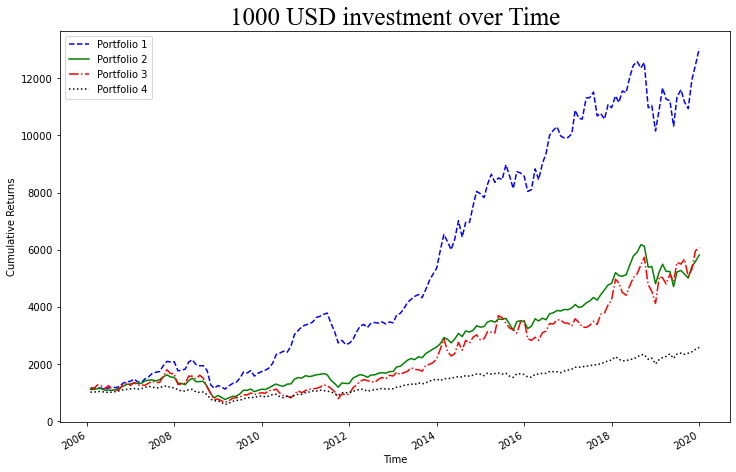

In [21]:
#Create plot area including axis
fig, ax = plt.subplots()

#Set the size of the plot
fig.set_size_inches(12, 8)

#Denote the Y and X variable. Then plot the line of both dataframes.
ax.plot(df_portfolio_1.index, df_portfolio_1.cr_1, linestyle='dashed', color='blue', label = 'Portfolio 1')
ax.plot(df_portfolio_2.index, df_portfolio_2.cr_1, linestyle='solid', color='green', label = 'Portfolio 2')
ax.plot(df_portfolio_3.index, df_portfolio_3.cr_1, linestyle='dashdot', color='red', label = 'Portfolio 3')
ax.plot(df_portfolio_4.index, df_portfolio_4.cr_1, linestyle='dotted', color='black', label = 'Portfolio 4')  

#Organize the tickers with an interval and rotation, making the time readable.
fig.autofmt_xdate() #

#Create a legend for the figure
ax.legend()

#Set the labels for the axes and create a title.
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Returns')
plt.title('1000 USD investment over Time', fontsize=25, color="Black", fontname='Times New Roman')

### Exercise 4
Differences between the performance of four portfolio's:
- We automatically see that Portfolio 1 creates the highest Cumulative Returns in December 2019. 
- We also see that the reference portfolio including the S&P 500 composite index has the lowest Cumulative Returns over time.
- We see that the Momentum Strategy in portfolio 3 is very similar to portfolio 2 in terms of Cumulative Returns.

Portfolio strategy 1 creates the highest Cumulative Returns, since it is the least stricted strategy. It computes the preferred weights of every asset in the portfolio and holds it these assets for 12 months if they are at least 0.0001. Therefore, the weights of the assets in the portfolio might differ based on their return and volatility. Therefore, it is flexible and follows the highest returns in the market (No transaction costs assumed).

We see that portfolio strategy 2 and 3 have similar results. This is due to the fact that they are very similar in approach. Portfolio strategy 2, gives all the assets that are above 0.0001 the same weight, which is quite a constraint compared to portfolio strategy 1. Portfolio strategy 3, also gives all the assets the same weight, but only select the the top 3 assets. So, the main difference is that Portfolio strategy 2 could have incorporated more than 5 assets in its portfolio, but the approach using equal weights for all assets is very similar.

Because portfolio strategy 2, is portfolio strategy 1 with more constraints, we see that the cumulative returns of the portfolio strategy 2 never exceeed the portfolio strategy 1. Whereas portfolio strategy 3 exceeds the portfolio strategy 1 around 2008. This is probably due to the risk of portfolio strategy 3 being higher at this point. At such a point the portfolio 3 is using only 5 highest CAR assets, where the risk of portfolio 2 could be lower since it has the possibility to diversify over more than 5 assets, but leaving portfolio 2 with a lower return.

The reference portfolio has the lowest CAR, which is not surprising since this portfolio contains the index of the 500 biggest companies in the US, meaning it is very diversified and contains mostly market risk. This low risk affects the return of the portfolio.

### Exercise 5
- Average Monthly Return
- Average Return Standard Deviation
- Average Sharpe Ratio

In [22]:
def portfolio_statistics(portfolio, portfolio_name):
    print('\033[1m',portfolio_name, '\033[0m')
    print('Average Monthly Returns:', np.average(portfolio['return']))
    print('Average Standard Deviation of Returns:',np.std(portfolio['return']))
    print('Average Sharpe Ratio of Portfolio:',(np.average(portfolio['return'])-np.average(df_rf.iloc[1:]))/np.std(portfolio['return']))
    print('\n')

In [23]:
portfolio_statistics(df_portfolio_1,'Portfolio 1')
portfolio_statistics(df_portfolio_2,'Portfolio 2')
portfolio_statistics(df_portfolio_3,'Portfolio 3')
portfolio_statistics(df_portfolio_4,'Portfolio 4')

 Portfolio 1 
Average Monthly Returns: 0.017277889324173318
Average Standard Deviation of Returns: 0.06046779475223569
Average Sharpe Ratio of Portfolio: 0.26991792526917385


 Portfolio 2 
Average Monthly Returns: 0.01209973307096127
Average Standard Deviation of Returns: 0.055438686266955466
Average Sharpe Ratio of Portfolio: 0.20100017158154787


 Portfolio 3 
Average Monthly Returns: 0.014607539132980275
Average Standard Deviation of Returns: 0.08696035531096931
Average Sharpe Ratio of Portfolio: 0.15697948180083734


 Portfolio 4 
Average Monthly Returns: 0.006522083333333335
Average Standard Deviation of Returns: 0.040728749447881324
Average Sharpe Ratio of Portfolio: 0.1366488239813911




#### Interpretation of the metrics
According to the printed metrics above, portfolio strategy 1 is the best strategy since it has the highest sharpe ratio and is therefore the best mean-variance portfolio. It creates the highest returns, but it hasn't got the lowest volatility. The volatility of portfolio 4 is the lowest, but that one also creates the lowest returns. Portfolio 2 and 3 are in the middle with their returns.

We see that the metrics are in line with our earlier conclusions in exercise 3. Portfolio 3 indeed has the highest volatility compared to the other portfolios. This explains the high number of peaks and throughs. It also explains that portfolio 3 is able to perform better and worse at some points in time compared to portfolio strategy 1 and 2. That is why, even though portfolio 3 has higher Cumulative Returns, the Sharpe Ratio of portfolio 2 is much higher than portfolio 3, because the volatility of portfolio 2 is much lower in relation to the returns.  

### Exercise 6
Regression of the excess returns of the four strategies against the FF3 and momentum factors.

In [24]:
# Creating a function that will make a dataframe for every portfolio that is optimal to work with for the regression.
def model_dataframe(portfolio):
    # Storing the rf, mktrf, smb, hml and momentum
    portfolio = portfolio.assign(rf = df_crsp_ff.rf.iloc[12:])
    portfolio = portfolio.assign(mktrf = df_crsp_ff.mktrf.iloc[12:])
    portfolio = portfolio.assign(smb = df_crsp_ff.smb.iloc[12:])
    portfolio = portfolio.assign(hml = df_crsp_ff.hml.iloc[12:])
    portfolio = portfolio.assign(umd = df_crsp_ff.umd.iloc[12:])
    
    # Creatin the excess portfolio returns using the variables in the dataframe.
    portfolio = portfolio.assign(excess_ret = (portfolio['return']-portfolio.rf))
    
    # Transform object to float.
    portfolio.excess_ret = pd.to_numeric(portfolio.excess_ret,downcast='float')
    return portfolio

In [25]:
# Call the function for every portfolio and store it into a new dataframe
df_portfolio_1 = model_dataframe(df_portfolio_1)
df_portfolio_2 = model_dataframe(df_portfolio_2)
df_portfolio_3 = model_dataframe(df_portfolio_3)
df_portfolio_4 = model_dataframe(df_portfolio_4)

In [26]:
# Estimate every model, using the excess returns on the mktrf, smb, hml and momentum factors.
model_1 = ols("excess_ret~mktrf+smb+hml+umd", df_portfolio_1)
est_1 = model_1.fit()

model_2 = ols("excess_ret~mktrf+smb+hml+umd", df_portfolio_2)
est_2 = model_2.fit()

model_3 = ols("excess_ret~mktrf+smb+hml+umd", df_portfolio_3)
est_3 = model_3.fit()

model_4 = ols("excess_ret~mktrf+smb+hml+umd", df_portfolio_4)
est_4 = model_4.fit()

In [27]:
# Print out every model under each other, with a bold font as specification.}
print('\033[1m' + 'Model Portfolio 1:'+ '\033[0m', est_1.summary(),'\n \n','\033[1m' + 'Model Portfolio 2:'+ '\033[0m',est_2.summary(),'\n \n','\033[1m' + 'Model Portfolio 3:'+ '\033[0m',est_3.summary(),'\n \n','\033[1m' + 'Model Portfolio 4:'+ '\033[0m',est_4.summary())


Model Portfolio 1:                             OLS Regression Results                            
Dep. Variable:             excess_ret   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     49.89
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           2.31e-27
Time:                        13:13:06   Log-Likelihood:                 300.10
No. Observations:                 168   AIC:                            -590.2
Df Residuals:                     163   BIC:                            -574.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0078      0.003 

#### Interpretation of Regression Results
The regression results of model 4 are exactly in line with our earlier conclusion in exercise 3, that portfolio strategy 4 is very similar to the market portfolio. We see that the $\beta$ coefficient of the mktrf in this model is almost equal to 1 and the model is almost perfectly explained if we look at the $R^2$.

Furthermore, we see that the coefficients of the Market Risk Premium and the Small-Big factor are statistically significant in every model, using a 5% significance level. This means that both the Market Risk Premium and the Small-Big factor significantly affect the excess returns of every portfolio strategy. 

Furthermore, The High-Low factor is in some models significant, but in others not. Therefore, we cannot add a general conclusiong for this factors. The Momentum factor on the other hand is insignificant (at 5%) in every model. This means that the Momentum factor has no significant effect on the excess returns of a portfolio strategy in this case.

### Exercise 7
Check all the tickers in the sample. Check the number of stocks we can invest in each year.

In [28]:
#We store the number of tickers of every set in df_tickers
df_tickers['date'] = pd.date_range(start="2006",end="2020", freq='Y').to_pydatetime().tolist()
df_tickers = df_tickers.set_index(['date'])
print(df_tickers.mean())
df_tickers.head(15)

number_tickers    102.785714
dtype: float64


,number_tickers
date,
2006-12-31,101
2007-12-31,104
2008-12-31,102
2009-12-31,104
2010-12-31,103
2011-12-31,103
2012-12-31,102
2013-12-31,101
2014-12-31,104


First of all, if we look at the portfolio's that we have constructed, we conclude that the Tickers that we can choose from in portfolio 1, 2 and 3 are similar, because we remove all the Tickers that contain NaN in both the formation and the holding period. 

Furthermore, the number of Ticker selected are similar in portfolio 1 and 2, since they use a threshold of 0.0001. Portfolio 3 always selects the 5 highest Cumulative Return Tickers, meaning it will always end up with 5 weights. At last, portfolio 4 is just an index without the choice of any Tickers.

We see that the number of stocks that you can invest in isn't changing that much. It is rather constant around 103, as we can see with the computed mean. We also see that the lowest number is 101 stocks and the highest number of stocks is 105. Meaning it varies a maximum of 4 stocks over time, which is not that many. 
We think these variations have little impact on the number of stocks chosen in portfolio 1 and 2, because the total number of stocks is 145 and 103 is already a fairly big amount of stocks that we can chose from 

Nevertheless, because we are constructing portfolio's on a yearly basis, we have still a restricted choice of stocks. If we would have constructed portfolio's on a monthly basis, then the the number of stocks we could choose from would be higher, because some stocks do have values for some months, but they just don't have all the 24 months of values.